In [5]:
from env import Env
import openai
import spotipy
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from spotipy.oauth2 import SpotifyClientCredentials 


In [6]:
# load API keys from .env file
openai.api_key = Env.OPEN_AI_KEY
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

## Create playlist using ChatGPT
Create seed playlist with ChatGPT for song characteristic analysis.

**\#PromptEngineering \#ChatGPT**

In [7]:
def get_playlist_recommendation(number_of_songs, genre):
    """
    Uses OpenAI's GPT-4 to generate a playlist recommendation based on the number of songs and genre.

    Args: 
        number_of_songs (int): number of songs in the playlist
        genre (str): genre of the playlist

    Returns:
        list: list of songs in the playlist
    """
    response=openai.ChatCompletion.create(
        model='gpt-4',
        messages=[
            {
                'role':'system',
                'content':
                """
                You are a music playlist designer.  You create playlists for people based on different inputs.

                Output all playlists in the following JSON format: 

                {
                    "playlist_name": "<name>",
                    "playlist_description": "<description>",
                    "playlist_tracks": [
                        "<track_name_1>",
                        "<track_name_2>",
                        ...
                    ]
                }

                Replace <track_name_n> with just the name of the song (do not add the artist) that you want in the playlist. 

                If you don't know what to do, type "help". 

                I want you to return in a json format only and not any extra text. 
                

                """
            },
        {
            'role':'user',
            'content':f"Can you create me a {genre} playlist of {number_of_songs} songs"
        }
        ] 
    )
    return json.loads(response.choices[0]['message']['content'])['playlist_tracks']
    

## Enrich songs with Spotify data
Use the Spotify API to add features to the songs for further analysis.

**\#WebAPI \#DataEnrichment**

In [8]:
def generate_dataframe_of_playlist(number_of_songs, genre):
    

    # extract songs from text response
    songs=get_playlist_recommendation('30', 'hip hop')

    # filter song attributes from spotify
    filter_song = lambda song: ({
        'id': song['id'],
        'name': song['name'],
        'artist': song['artists'][0]['name'],
        'album': song['album']['name'],
        'length': song['duration_ms'],
        'explicit': song['explicit'],
        'popularity': song['popularity'],
        'type': song['type']
    }) 

    # get the spotify song ids
    spotify_songs = [ 
        filter_song(spotify.search(song)['tracks']['items'][0]) 
        for song in songs 
    ]

    # get the spotify song features
    spotify_songs = [
        {**song, **spotify.audio_features(song['id'])[0]}
        for song in spotify_songs
    ]

    spotify_songs_df = pd.DataFrame(spotify_songs)
    return spotify_songs_df 

In [9]:
hip_pop_songs=generate_dataframe_of_playlist('100', 'hip hop')[['popularity','danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','tempo']]

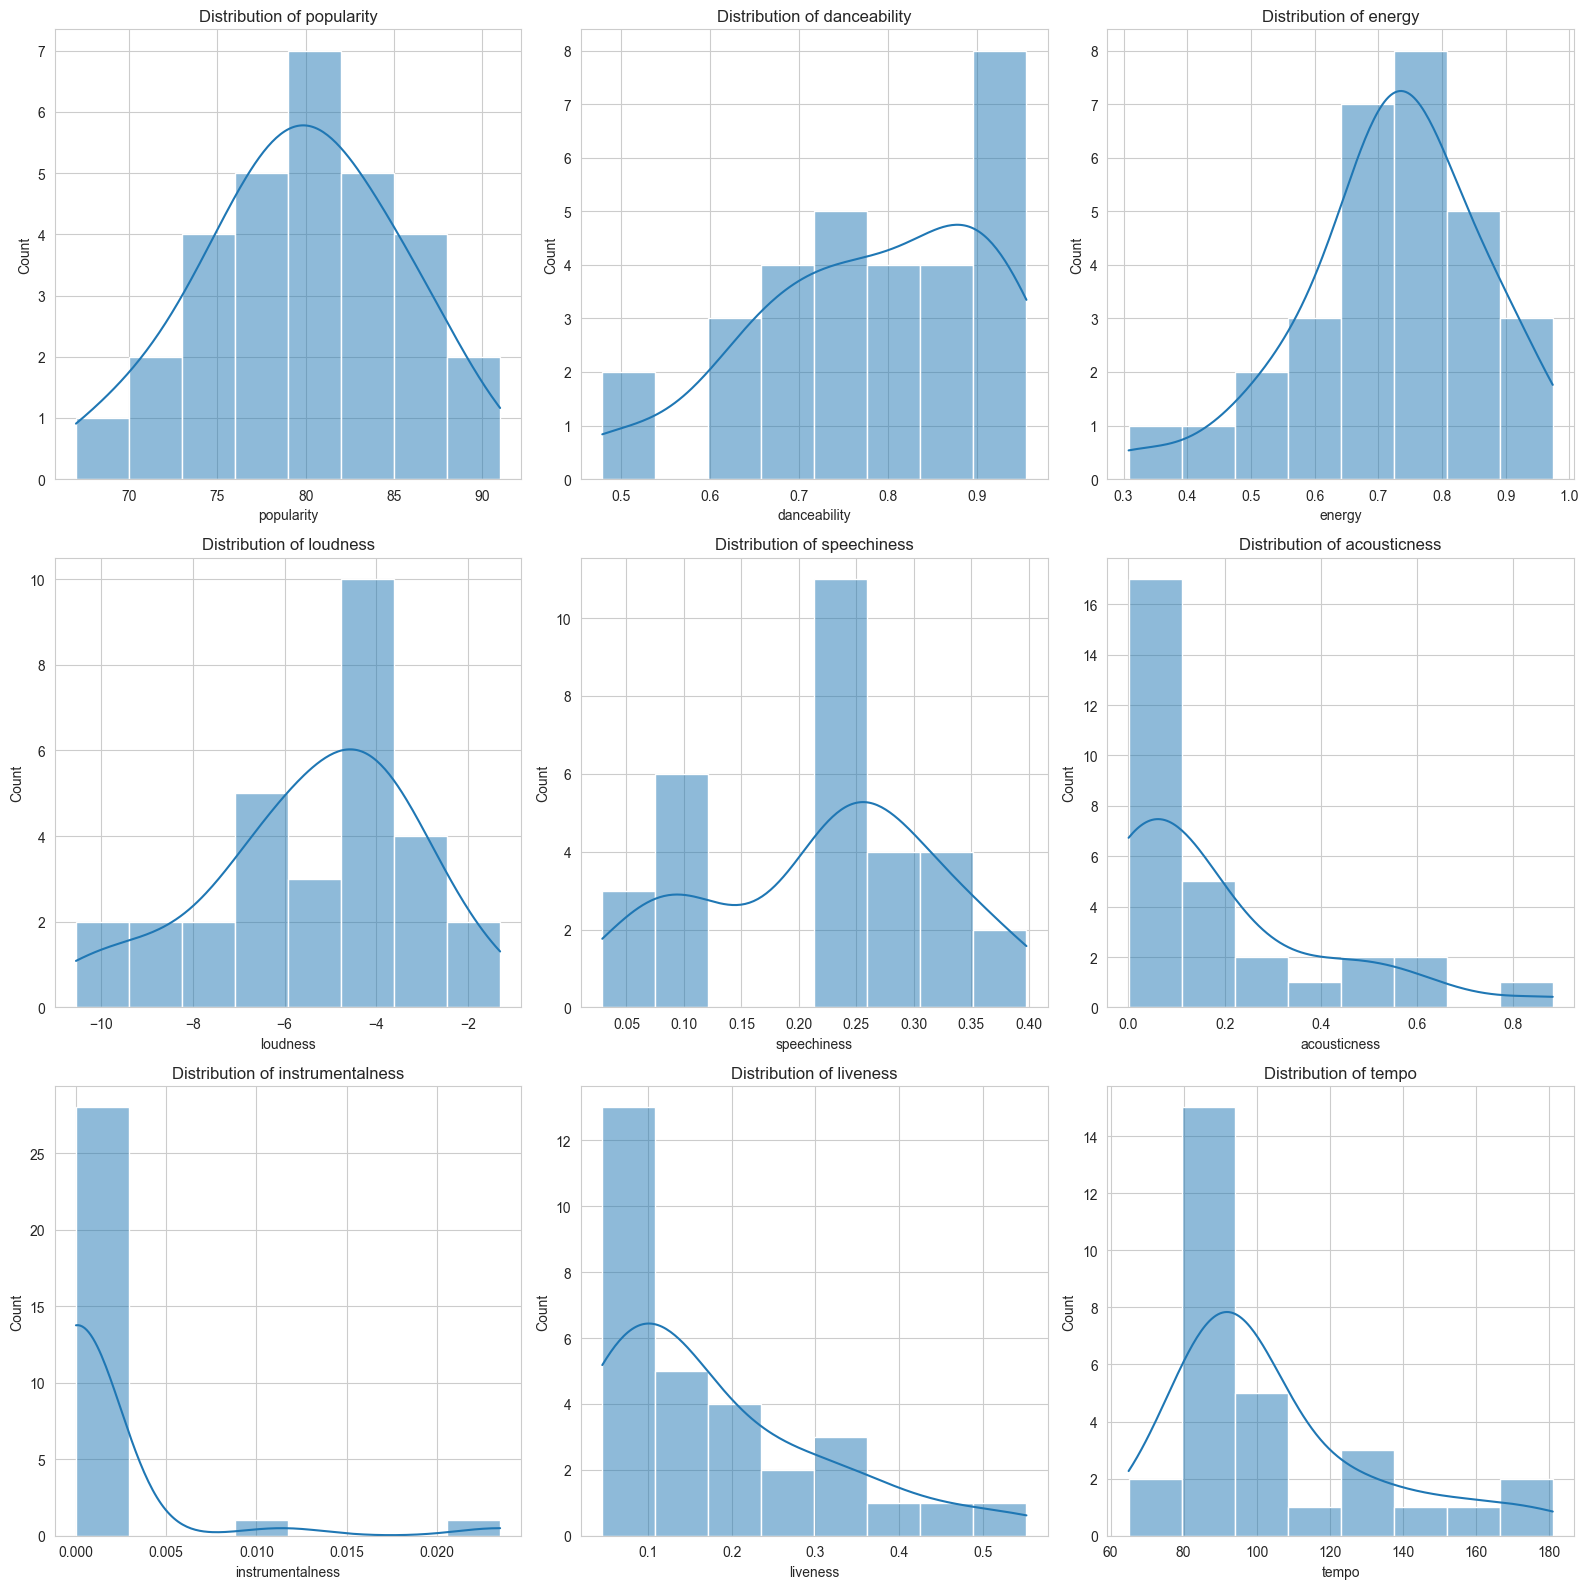

In [10]:
plt.figure(figsize=(16, 16))
for column in hip_pop_songs.columns:
    plt.subplot(3, 3, list(hip_pop_songs.columns).index(column) + 1)
    sns.histplot(hip_pop_songs[column],bins=8, kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


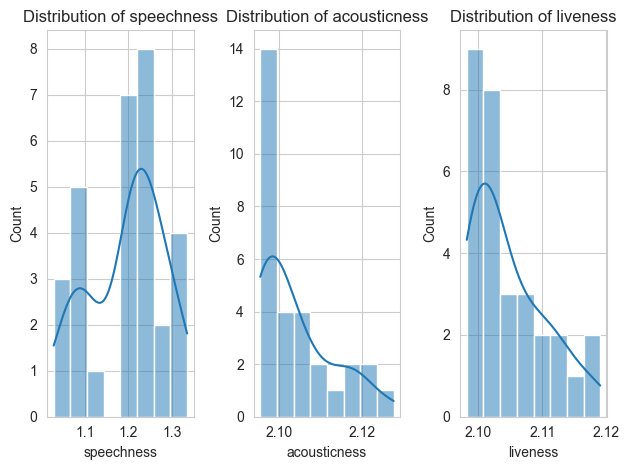

In [16]:
## Log transform data that are exponentially distributed
hip_pop_songs[['speechness','acousticness','liveness']]=np.log1p(hip_pop_songs[['speechiness','acousticness','liveness']])+1
log_transformed_hip_pop_songs=hip_pop_songs[['speechness','acousticness','liveness']]
for column in log_transformed_hip_pop_songs.columns:
    plt.subplot(1, 3, list(log_transformed_hip_pop_songs.columns).index(column) + 1)
    sns.histplot(hip_pop_songs[column],bins=8, kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [12]:
## Log transform data that are exponentially distributed
hip_pop_songs[['speechness','acousticness','liveness']]=np.log1p(hip_pop_songs[['speechiness','acousticness','liveness']])+1
for column in hip_pop_songs.columns:
    plt.subplot(3, 3, list(hip_pop_songs.columns).index(column) + 1)
    sns.histplot(hip_pop_songs[column],bins=8, kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()



## Build a linear regression model to predict popularity
model = LinearRegression()

## Fit the model
X = hip_pop_songs[['danceability','energy','loudness','speechiness','acousticness',
                  'instrumentalness','liveness','tempo']]
y = hip_pop_songs['popularity']
model.fit(X, y)

## Print the model coefficients
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

Intercept: 186.33266554575337
Coefficients: [-3.31302682e-01 -2.27330400e+01  1.45709108e-01 -8.00954358e+00
 -2.73241261e+01 -2.98275793e+01 -2.22035778e+01  2.07940741e-04]


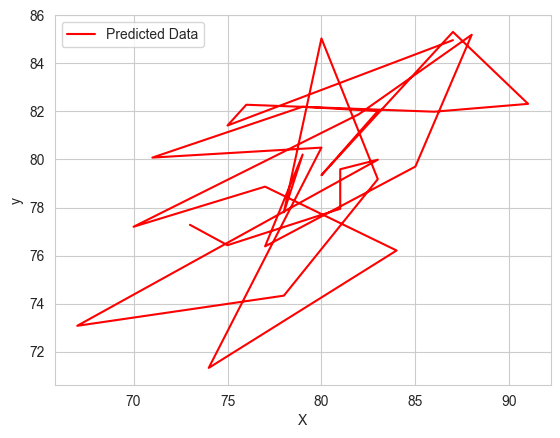

In [14]:
# Predict on the same data
y_pred = model.predict(X)

# Plot the predicted data points
plt.plot(y, y_pred, label="Predicted Data", color="red")

# Add labels and a legend
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

# Show the plot
plt.show()

<Axes: >

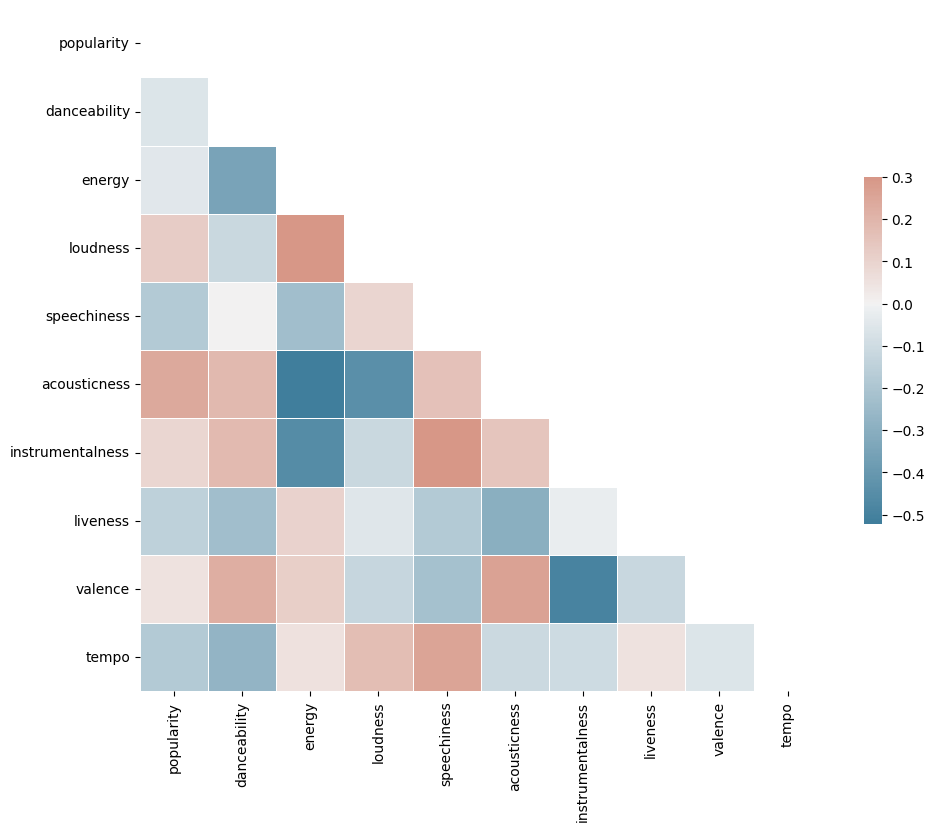

In [25]:
corr=spotify_songs_df[['popularity','danceability','energy','loudness','speechiness','acousticness',
                  'instrumentalness','liveness','valence','tempo']].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})